Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns
import matplotlib.pyplot as plt

Accurecy Generator

In [ ]:
def accuracy_list(y_test, y_pred):
  result = {}
  result['Accuracy'] = accuracy_score(y_test, y_pred)
  result['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
  result['Classification Report'] = classification_report(
      y_test, y_pred, output_dict=True)
  result['Precision'] = precision_score(y_test, y_pred, average='weighted')
  result['Recall'] = recall_score(y_test, y_pred, average='weighted')
  result['y_pred'] = y_pred
  return result

Model Training

In [ ]:
def model_train(X, y, random_state):
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=random_state)

  results = {}

  logistic_model = LogisticRegression()
  logistic_model.fit(X_train, y_train)
  y_pred_logistic = logistic_model.predict(X_test)
  results['Logistic Regression'] = accuracy_list(y_test, y_pred_logistic)

  dt_model = DecisionTreeClassifier()
  dt_model.fit(X_train, y_train)
  y_pred_dt = dt_model.predict(X_test)
  results['Decision Tree'] = accuracy_list(y_test, y_pred_dt)

  knn_model = KNeighborsClassifier(n_neighbors=5)
  knn_model.fit(X_train, y_train)
  y_pred_knn = knn_model.predict(X_test)
  results['K-Nearest Neighbors'] = accuracy_list(y_test, y_pred_knn)

  neural_networks_model = Sequential([
      Flatten(input_shape=(X_train.shape[1],)),
      Dense(128, activation='relu'),
      Dense(len(y.unique()), activation="softmax")
  ])

  neural_networks_model.compile(optimizer=Adam(0.001),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  neural_networks_model.fit(
      X_train, y_train, epochs=10, batch_size=128, verbose=0)

  y_pred_prob = neural_networks_model.predict(X_test)
  y_pred_neural = np.argmax(y_pred_prob, axis=1)
  results['Neural Networks'] = accuracy_list(y_test, y_pred_neural)

  return results, y_test

Load the dataset

In [ ]:
data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Food_Delivery_Times_Classification.csv')

Data before encoding categorical variables

In [ ]:
data.head(3)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Speed
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,Average
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,Slow
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,Average


In [ ]:
data.shape

(1000, 9)

Check all the null values

In [ ]:
data.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Speed,0


Dropping rows with missing values

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(883, 9)

Check all the null values after dropping null values

In [ ]:
data.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Speed,0


Encode categorical variables

In [ ]:
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col, encoder in label_encoders.items():
  data[col] = encoder.fit_transform(data[col]) #Encode categorical variables to numerical
  mapping = {category: code for code, category in enumerate(encoder.classes_)}
  print(mapping)

{'Clear': 0, 'Foggy': 1, 'Rainy': 2, 'Snowy': 3, 'Windy': 4}
{'High': 0, 'Low': 1, 'Medium': 2}
{'Afternoon': 0, 'Evening': 1, 'Morning': 2, 'Night': 3}
{'Bike': 0, 'Car': 1, 'Scooter': 2}
{'Average': 0, 'Fast': 1, 'Slow': 2}


<ipython-input-352-f6b10019595e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = encoder.fit_transform(data[col]) #Encode categorical variables to numerical
<ipython-input-352-f6b10019595e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = encoder.fit_transform(data[col]) #Encode categorical variables to numerical
<ipython-input-352-f6b10019595e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Data after encoding categorical variables

In [ ]:
data.head(3)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Speed
0,522,7.93,4,1,0,2,12,1.0,0
1,738,16.42,0,2,1,0,20,2.0,2
2,741,9.52,1,1,3,2,28,1.0,0


Visualizing the correlation matrix using a heatmap
- Yellow: Represents weak or no correlation (values close to 0).
- Green: Represents moderate correlation (positive or negative).
- Blue: Represents strong positive correlation (values close to 1) or strong negative correlation (values close to -1, depending on the shade).

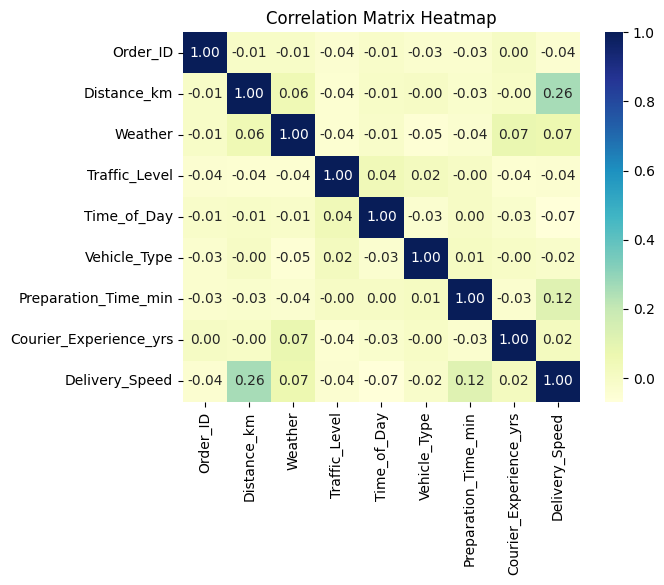

In [ ]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Matrix Heatmap")
plt.show()

Identifying Highly Correlated Features

In [ ]:
correlation_threshold = 0.70
high_corr_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[0]):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append(
                (correlation_matrix.index[i], correlation_matrix.columns[j]))

print(
    f"Highly correlated feature pairs (>|{correlation_threshold}|): {high_corr_pairs}")

Highly correlated feature pairs (>|0.7|): []


Drop one feature from each pair

In [ ]:
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.add(pair[1])

print(f"Features to drop: {features_to_drop or None}")
data = data.drop(columns=features_to_drop)

Features to drop: None


Dataset size after dropping

In [ ]:
data.shape

(883, 9)

In [ ]:
X = data.drop('Delivery_Speed', axis=1)
y = data['Delivery_Speed']

Feature Scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

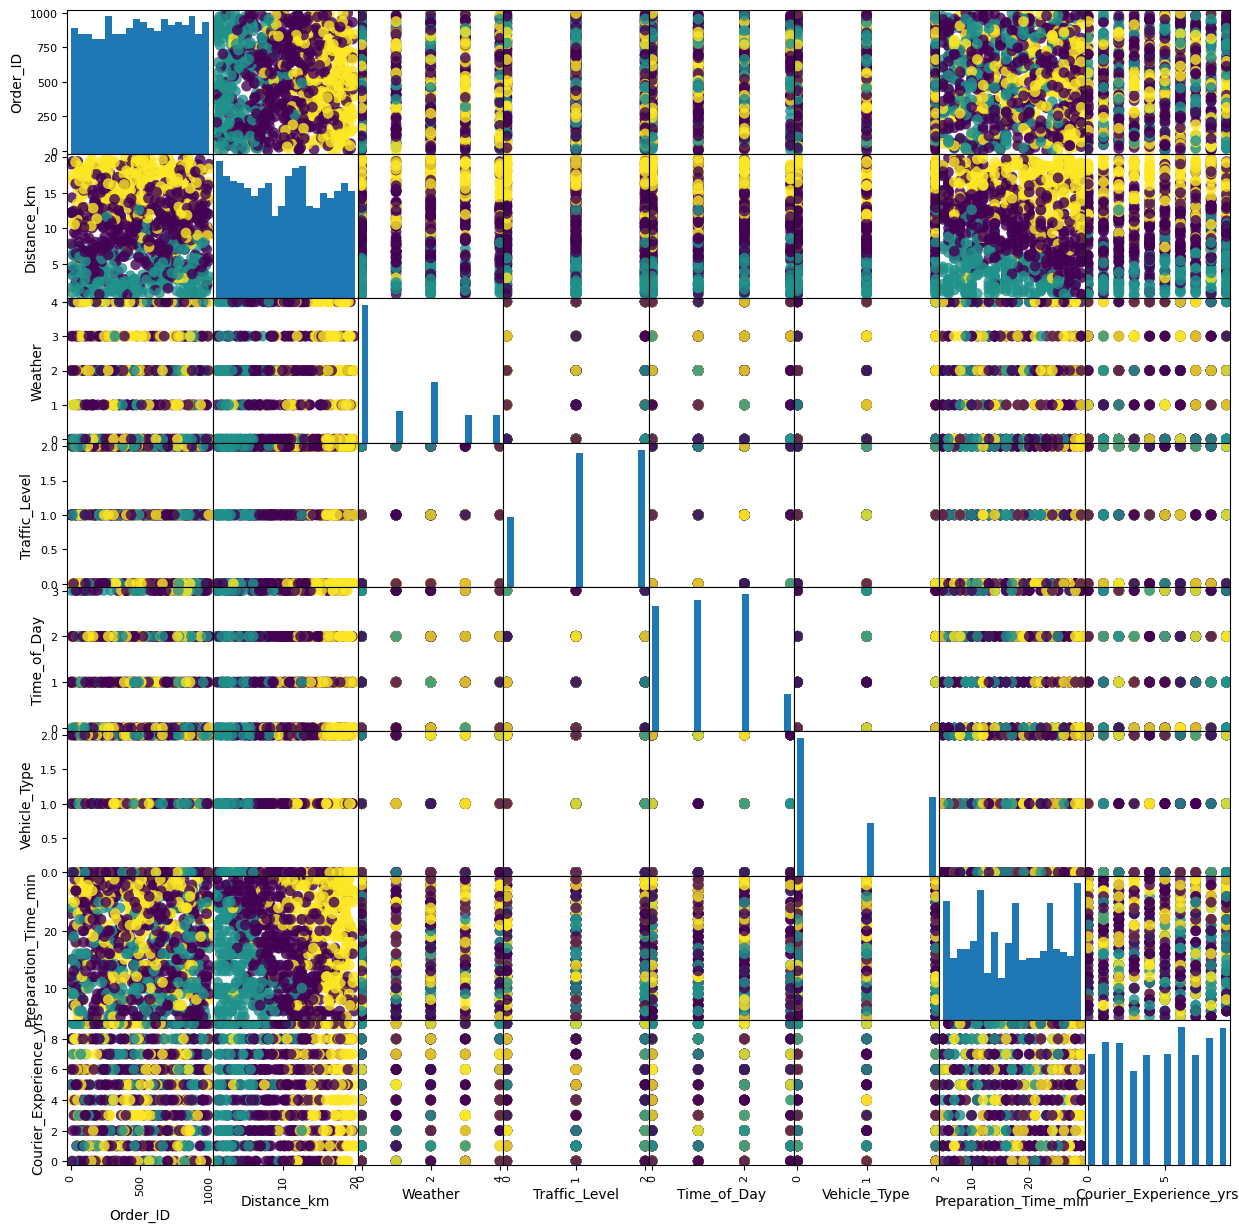

In [ ]:
selected_features = correlation_matrix.columns[:8]
scatter_matrix = pd.plotting.scatter_matrix(
    pd.DataFrame(X[selected_features], columns=selected_features),
    c=y,
    figsize=(15, 15),
    marker='o',
    hist_kwds={'bins': 20},
    s=60,
    alpha=0.8,
)

plt.show()

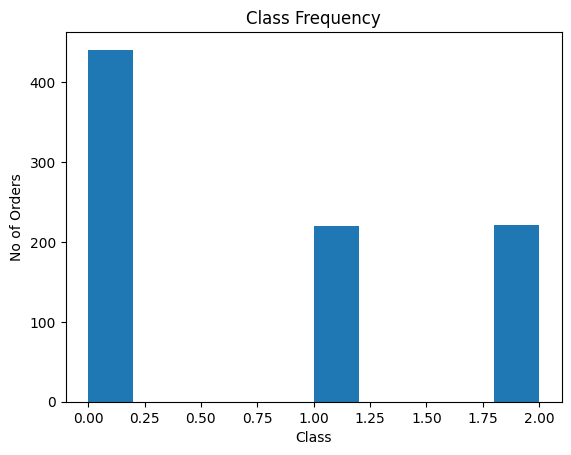

In [ ]:
fig, ax = plt.subplots()
ax.hist(y)
ax.set_title('Class Frequency')
ax.set_xlabel('Class')
ax.set_ylabel('No of Orders')
plt.show()

Starting training the model

In [ ]:
random_state = 42
res, y_test = model_train(X_scaled, y, random_state)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Bar Chart of the accuracy of each model

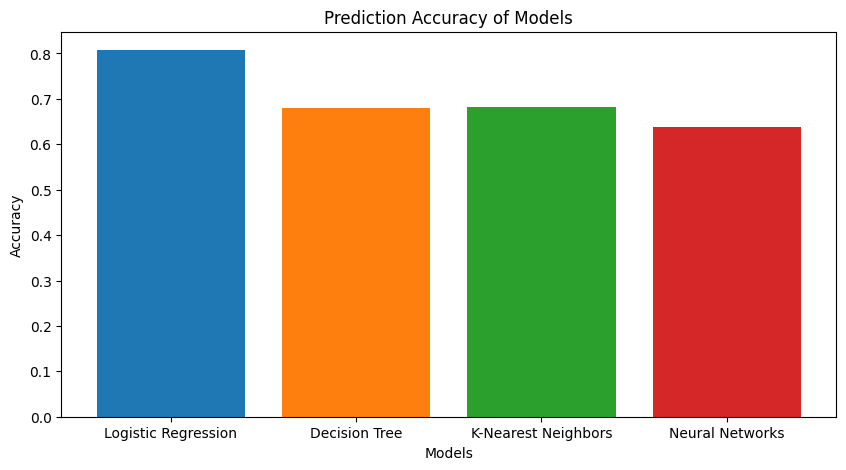

In [ ]:
model_names = []
accuracies = []
precisions = []
recalls = []

for model in res:
  model_names.append(model)
  accuracies.append(res[model]['Accuracy'])
  precisions.append(res[model]['Precision'])
  recalls.append(res[model]['Recall'])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color=colors)
plt.title('Prediction Accuracy of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

Precision and recall comparison

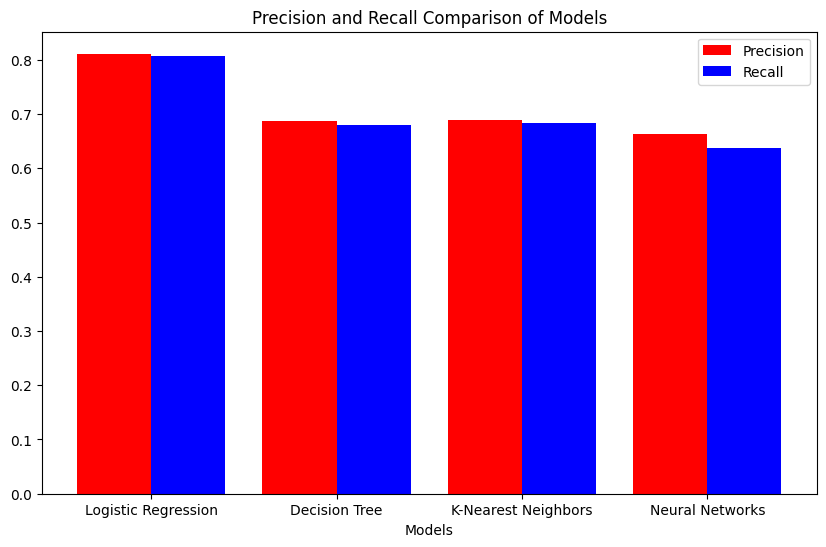

In [ ]:
x = np.arange(len(model_names))
width = 0.40

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, precisions, width, label='Precision', color='red')
ax.bar(x + width/2, recalls, width, label='Recall', color='blue')

ax.set_xlabel('Models')
ax.set_title('Precision and Recall Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.show()

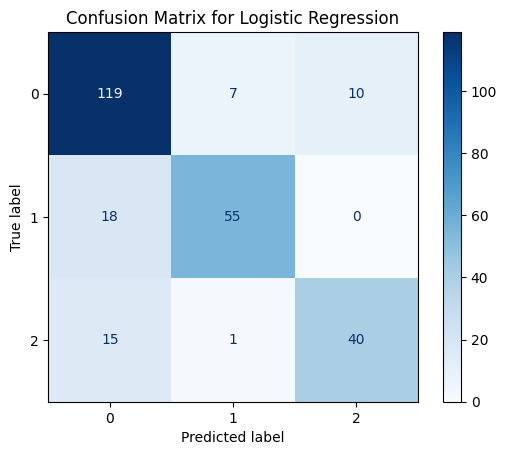

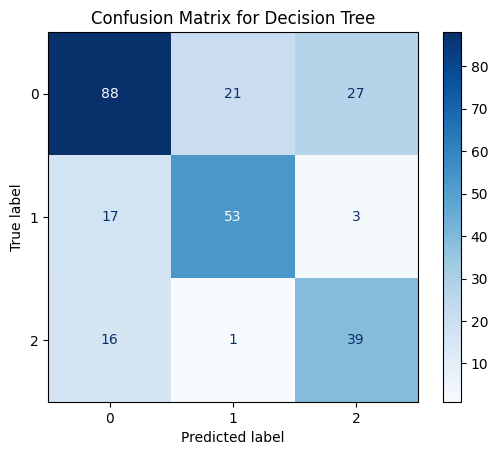

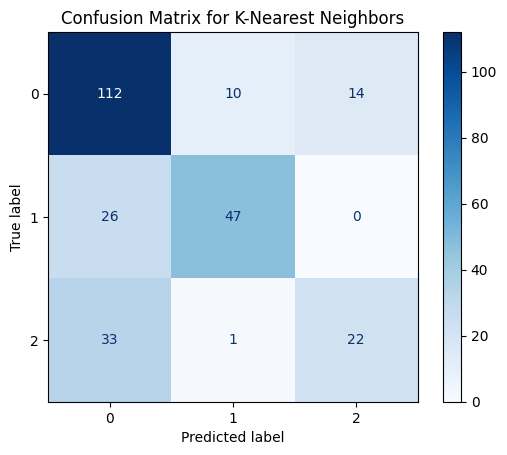

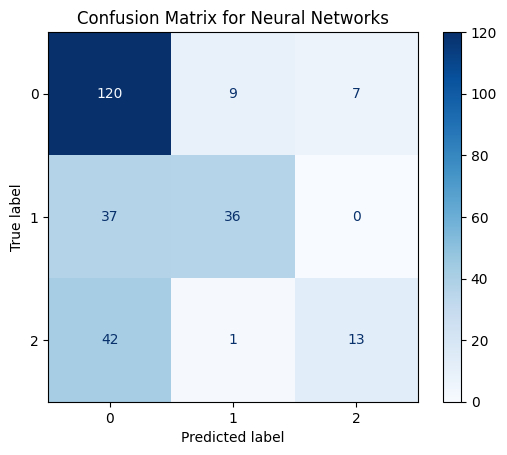

In [ ]:
for model_name, metrics in res.items():
  cm = metrics['Confusion Matrix']
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(cmap='Blues')
  plt.title(f'Confusion Matrix for {model_name}')
  plt.show()

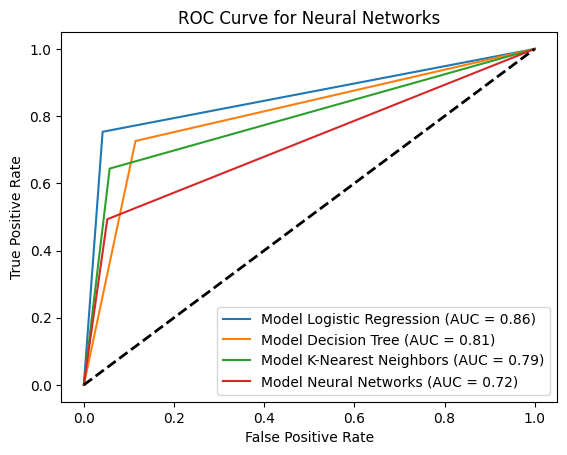

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

for model_name, metrics in res.items():
  y_pred_prob = metrics['y_pred']
  y_pred_binarized = label_binarize(y_pred_prob, classes=np.unique(y))

  fpr = {}
  tpr = {}
  roc_auc = {}

  fprNew = None
  tprNew = None
  aoc = 0

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])
    # plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    if roc_auc[i] > aoc:
        aoc = roc_auc[i]
        fprNew = fpr[i]
        tprNew = tpr[i]
  plt.plot(fprNew, tprNew, label=f'Model {model_name} (AUC = {aoc:.2f})')

#   plt.figure()
#   for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title(f'ROC Curve for {model_name}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
for model in res:
  print(model)
  for metric in res[model]:
    print(f"{metric}: {res[model][metric]}")
  print()

Logistic Regression
Accuracy: 0.8075471698113208
Confusion Matrix: [[119   7  10]
 [ 18  55   0]
 [ 15   1  40]]
Classification Report: {'0': {'precision': 0.7828947368421053, 'recall': 0.875, 'f1-score': 0.8263888888888888, 'support': 136.0}, '1': {'precision': 0.873015873015873, 'recall': 0.7534246575342466, 'f1-score': 0.8088235294117647, 'support': 73.0}, '2': {'precision': 0.8, 'recall': 0.7142857142857143, 'f1-score': 0.7547169811320755, 'support': 56.0}, 'accuracy': 0.8075471698113208, 'macro avg': {'precision': 0.8186368699526595, 'recall': 0.7809034572733203, 'f1-score': 0.7966431331442431, 'support': 265.0}, 'weighted avg': {'precision': 0.8113352563799436, 'recall': 0.8075471698113208, 'f1-score': 0.8064043678465809, 'support': 265.0}}
Precision: 0.8113352563799436
Recall: 0.8075471698113208
y_pred: [0 1 0 2 0 2 0 0 0 0 2 0 1 2 0 0 1 2 0 1 0 0 2 0 0 2 0 0 1 0 2 0 1 0 0 1 0
 1 0 1 1 1 2 0 0 1 2 0 1 2 1 2 0 2 0 0 1 0 0 0 1 2 0 0 0 0 0 0 2 0 0 2 0 0
 2 0 1 1 0 1 1 1 2 1 0 0 0 1